# Kimia Esmaili- 610398193

# Defining the project

This Project is based on a recent study done by Murat Koklu et al. 
They determined the species of grapevine leaves as following: deep learning-based classification was conducted by using images of grapevine leaves. For this purpose, images of 500 vine leaves belonging to 5 species were taken with a special self-illuminating system.
<br>
Here is the link to the study:
https://www.sciencedirect.com/science/article/abs/pii/S0263224121013142?via%3Dihub
<br>
Based on their study abstract: The main product of grapevines is grapes that are consumed fresh or processed. In addition, grapevine leaves are harvested once a year as a by-product. The species of grapevine leaves are important in terms of price and taste.
<br>
Here we want to use some fine-tuning and deep learning models that are pre-trained to classify the grapevine leaves images.


# Importing

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from keras.layers import Dense
from keras.models import Sequential

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D

from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, RandomTranslation
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.model_selection import train_test_split

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow

For making models and doing the preprocessing of the data we need to use some libraries imported above.


# Pre-processing

In [ ]:
BATCH_SIZE = 16
IMG_SIZE = (224, 224)

directory = "dataset"
train_dataset = image_dataset_from_directory(directory, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, validation_split=0.2,
                                                                                                                     subset='training',
                                                                                                                               seed=42)

test_dataset = image_dataset_from_directory(directory, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, validation_split=0.2,
                                                                                                                  subset='validation',
                                                                                                                              seed=42)

Found 500 files belonging to 5 classes.
Using 400 files for training.
Found 500 files belonging to 5 classes.
Using 100 files for validation.


We took the images from directory by tensorflow.keras.preprocessing.image_dataset_from_directory(). We have 500 images with the batch_size of 16 and image size of (224 * 224 * 3). The size of the trainig dataset is 320, the validation dataset size is 80 and the test dataset size is 100.

2022-08-04 15:14:34.648560: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


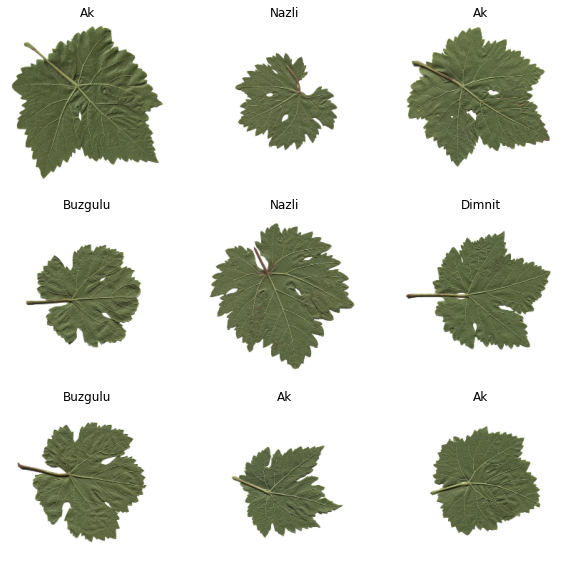

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

then we visualized some of the leaves images with their corresponding labels.

In [ ]:
X_train = np.empty((0,224, 224, 3))
y_train = np.array([])
for x, y in train_dataset:
    X_train = np.concatenate([X_train, x.numpy()/255.])
    y_train = np.concatenate([y_train, y.numpy()])

In [ ]:
X_train_target, X_val, y_train_target, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(X_train_target.shape, X_val.shape)

(320, 224, 224, 3) (80, 224, 224, 3)


In [ ]:
X_test = np.empty((0,224, 224, 3))
y_test = np.array([])
for x, y in test_dataset:
    X_test = np.concatenate([X_test, x.numpy()/255.])
    y_test = np.concatenate([y_test, y.numpy()])

Then we made train/validation/test datasets as above.

In [ ]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.3))
    data_augmentation.add(RandomZoom(0.5,0.2))
    return data_augmentation

We defined a data augmeter function that will be applied to the train/validation dataset. The said function does random zooming, flipping and rotating. 

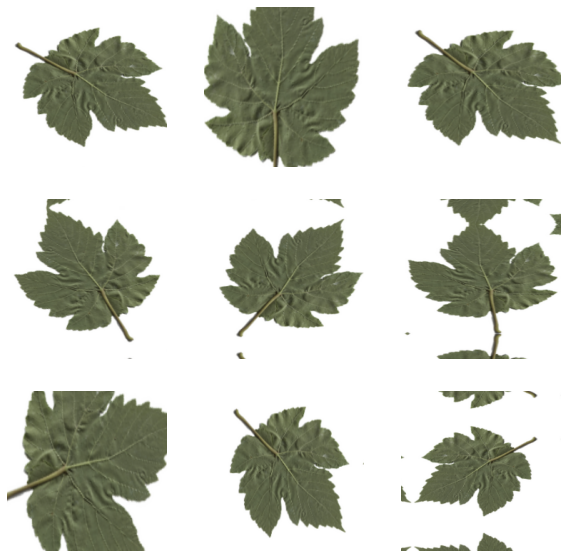

In [ ]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[10]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Here we wanted to see some augmented images.

# Autoencoder

Autoencoder is an unsupervised artificial neural network that is trained to copy its input to output. In the case of image data, the autoencoder will first encode the image into a lower-dimensional representation, then decodes that representation back to the image.
Here we make a model for autoencoder.

In [ ]:
inputs = layers.Input(shape=(224, 224, 3))

#Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

#Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

#Autoencoder
autoencoder = Model( inputs, x)
autoencoder.compile( optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="binary_crossentropy")
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_13 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 112, 112, 32)     9248

Encoder-Decoder automatically consists of the following two structures:
<br>
1: The encoder: This network downsamples the data into lower dimensions.
<br>
2: The decoder: This network reconstructs the original data from the lower dimension representation.
<br>
The representation of lower dimension (output of encoder network) is usually known as latent space representation.
<br>
The input layer for this model has the shape (224 * 224 * 3), we add some convolutional layers with activation='relu' and padding='same' for the encoder part. After that we add some transpose convolutional layers(Conv2DTranspose) with activation='relu' and padding='same' for the decoder part. these layers upsamples the data so at the end we end up with a (224 * 224 * 3) output which has the same size like its first layer. Based on the summary of the model, the number of parameters for train is 449,795.

In [ ]:
autoencoder.fit(X_train,X_train, epochs=20,shuffle = True, batch_size = 16)

Epoch 1/20
25/25 [==============================] - 10s 381ms/step - loss: 0.5053
Epoch 2/20
25/25 [==============================] - 9s 376ms/step - loss: 0.3685
Epoch 3/20
25/25 [==============================] - 10s 382ms/step - loss: 0.2844
Epoch 4/20
25/25 [==============================] - 9s 368ms/step - loss: 0.2382
Epoch 5/20
25/25 [==============================] - 9s 365ms/step - loss: 0.2310
Epoch 6/20
25/25 [==============================] - 9s 366ms/step - loss: 0.2290
Epoch 7/20
25/25 [==============================] - 9s 366ms/step - loss: 0.2277
Epoch 8/20
25/25 [==============================] - 9s 369ms/step - loss: 0.2266
Epoch 9/20
25/25 [==============================] - 9s 370ms/step - loss: 0.2256
Epoch 10/20
25/25 [==============================] - 9s 370ms/step - loss: 0.2247
Epoch 11/20
25/25 [==============================] - 9s 368ms/step - loss: 0.2238
Epoch 12/20
25/25 [==============================] - 9s 368ms/step - loss: 0.2230
Epoch 13/20
25/25 [====

As you can see we fit the encoder to the test/validation set for batch_size 16 and 20 epochs. The loss function is set to binary_crossentropy and the optimizer for this fitting is adam with learning rate = 0.001.

In [ ]:
predicts = autoencoder.predict(X_train)

We constructed new images for the trainig dataset by autoencoder.predict() function, as shown above.

In [ ]:
print('the shape of autoencoder prediction is: ', predicts.shape)

the shape of autoencoder prediction is:  (400, 224, 224, 3)


By this we generated 400 images of size (224,224,3) with range of (0,1).

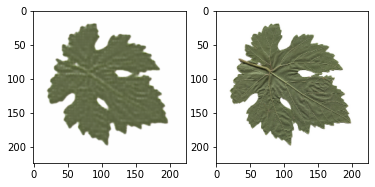

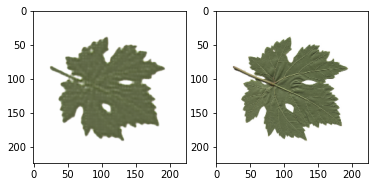

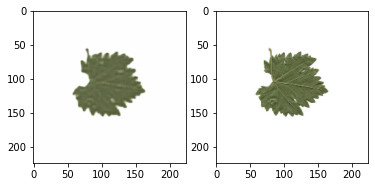

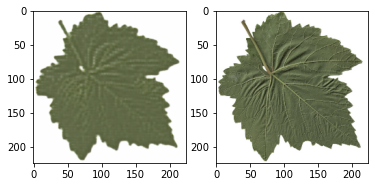

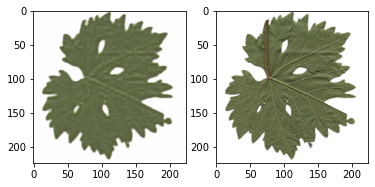

In [ ]:
for i in range(5):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow( predicts[i] )
    axarr[1].imshow( X_train[i] )

We compared the denoised image derived from autoencoder and the original image in the above cell.

In [ ]:
def display(array1):
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]

    plt.figure(figsize=(10, 7))
    for i, image1 in enumerate(images1):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(224, 224,3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

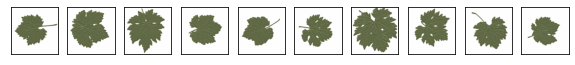

In [ ]:
display(predicts)

As you can see the original image is superior to the reconstructed image. later we see the accuracy of these images.
<br>
We also displayed some images of denoised images.

# Model on denoised images


xception deep learning model is an inception module in convolutional neural networks as being an intermediate step in-between regular convolution and the depthwise separable convolution operation (a depthwise convolution followed by a pointwise convolution).
<br> In this project, we are using xception deep learning model.

In [ ]:
EPOCHS = 13
LR_START = 0.00001
LR_MAX = 0.0001 * 0.6
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 3
LR_EXP_DECAY = .5

We set leaning rate schedule configurations for this model in the above.

In [ ]:
def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

Learning rate schedule: 1e-05 to 6e-05 to 1.08e-05


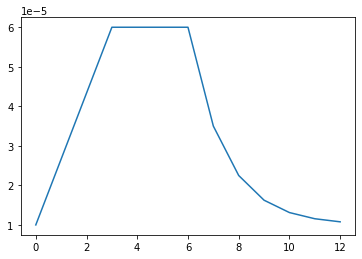

In [ ]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

This LearningRateScheduler is given from Practical Machine Learning for Computer Vision(book)

In [ ]:
base_model = tf.keras.applications.xception.Xception( input_shape=(224,224,3), include_top=False, weights='imagenet')
base_model.trainable = True

input_shape = (224,224,3)

inputs = tf.keras.Input(shape=input_shape) 
x = data_augmenter()(inputs)
x = tf.keras.applications.xception.preprocess_input(x)
x = base_model(x) 
x = layers.GlobalAveragePooling2D()(x) 
x = layers.Dropout(0.5)(x)
x = layers.Flatten()(x)

outputs = layers.Dense(5,activation = 'softmax')(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_5 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0   

Here we constructed our main model:
<br>
firt we got the pre-trained xception model from tf.keras.applications with input shape of (224,224,3). this model is trained on imageNet dataset which has 1000 class.
<br>
firstly we set all the 132 layers of xception 'trainable' so all the wights will be updated. We set our 23m parameter xception model to those augmented images, after augmeting the data in the model. Then we use GlobalAveragePooling2D layer and drop out layer with parameter 0.5, and we flattened the units(neurons), at the end we pass these 2048 weights to the softmax layer with 5 units.
<br>
The summary of our model is shown above.

In [ ]:
denoise_train = autoencoder.predict(X_train)

In [ ]:
y_train = y_train.astype('uint8')
y_test = y_test.astype('uint8')
y_val = y_val.astype('uint8')

we constructed our (X, y) pair for the fitting part.

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

history = model.fit(
    x=denoise_train*255.,
    y=y_train,
    validation_data=(X_val*255., y_val),
    callbacks = [lr_callback],
    epochs = EPOCHS,
    batch_size=16
)


Epoch 00001: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/13
25/25 [==============================] - 63s 2s/step - loss: 1.6404 - accuracy: 0.2050 - val_loss: 1.5978 - val_accuracy: 0.2125 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler setting learning rate to 2.6666666666666667e-05.
Epoch 2/13
25/25 [==============================] - 62s 2s/step - loss: 1.5719 - accuracy: 0.2775 - val_loss: 1.4888 - val_accuracy: 0.4125 - lr: 2.6667e-05

Epoch 00003: LearningRateScheduler setting learning rate to 4.3333333333333334e-05.
Epoch 3/13
25/25 [==============================] - 61s 2s/step - loss: 1.4155 - accuracy: 0.4575 - val_loss: 1.3606 - val_accuracy: 0.4500 - lr: 4.3333e-05

Epoch 00004: LearningRateScheduler setting learning rate to 6e-05.
Epoch 4/13
25/25 [==============================] - 64s 3s/step - loss: 1.2085 - accuracy: 0.5650 - val_loss: 1.1819 - val_accuracy: 0.6250 - lr: 6.0000e-05

Epoch 00005: LearningRateScheduler setting learning rate to 6e-05

Then we compiled the model with Adam optimizer, sparse_categorical_crossentropy loss function and accuracy for metrics.
<br>
After that we fit the model on trainig dataset, using validation dataset with  batch size = 16 and epoch = 13. we got the results shown above.

<AxesSubplot:>

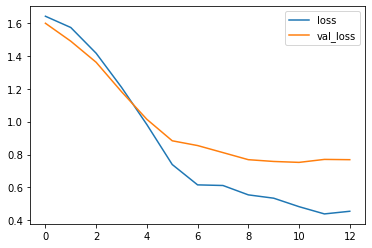

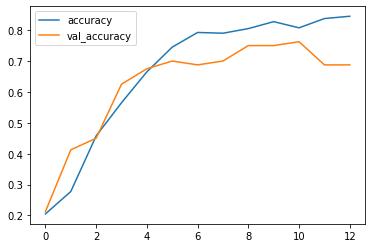

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

So we had 68% accuracy on validation dataset and 84.5% accuracy on trainig dataset. We ploted loss based on epoch, shown above.

In [ ]:
base_model2 = model.layers[4]
base_model2.trainable = True

fine_tune_at = 100

for layer in base_model2.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
print("Number of layers in the model: ", len(base_model2.layers))

Number of layers in the model:  132


Here we fine-tuned the layers which was done by appling trainable method on layers of xception model. There are 132 layers in xception model.
<br>We set trainable mode of our first 100 layers to 'False' and set the rest of our layers to 'True'. By doing this only the weights of the last 32 layers will be updated. You can see the procedure in the above.

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
metrics= ['accuracy']
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = optimizer,
              metrics=metrics)

In [ ]:
Checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("save_model_xception_autoencoder.h5", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

callbacks = [Checkpoint_cb, early_stopping]

In [ ]:
initial_epochs = 13
new_epochs = 15
total_epochs =  initial_epochs + new_epochs

history_fine = model.fit(x=denoise_train*255., y=y_train,validation_data=(X_val*255., y_val),
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         callbacks=callbacks)

Epoch 13/28
13/13 [==============================] - 25s 2s/step - loss: 0.3538 - accuracy: 0.8800 - val_loss: 0.3643 - val_accuracy: 0.8625
Epoch 14/28
13/13 [==============================] - 25s 2s/step - loss: 0.3261 - accuracy: 0.8850 - val_loss: 0.3890 - val_accuracy: 0.8750
Epoch 15/28
13/13 [==============================] - 25s 2s/step - loss: 0.3032 - accuracy: 0.8800 - val_loss: 0.3198 - val_accuracy: 0.8875
Epoch 16/28
13/13 [==============================] - 26s 2s/step - loss: 0.3322 - accuracy: 0.8775 - val_loss: 0.2533 - val_accuracy: 0.9375
Epoch 17/28
13/13 [==============================] - 25s 2s/step - loss: 0.3206 - accuracy: 0.8850 - val_loss: 0.2481 - val_accuracy: 0.9125
Epoch 18/28
13/13 [==============================] - 25s 2s/step - loss: 0.2207 - accuracy: 0.9150 - val_loss: 0.2104 - val_accuracy: 0.9250
Epoch 19/28
13/13 [==============================] - 25s 2s/step - loss: 0.2411 - accuracy: 0.9200 - val_loss: 0.1908 - val_accuracy: 0.9375
Epoch 20/28
1

In the fine-tuning section, we set the learning rate of our adam optimizer to 0.0001 and we set early stopping call back function in fitting part, then we fit the model 15 more epochs. You can see the result as shown above.

<AxesSubplot:>

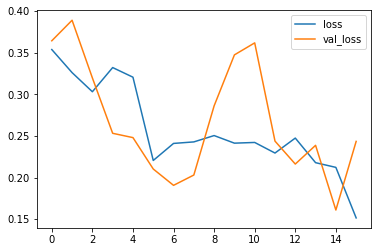

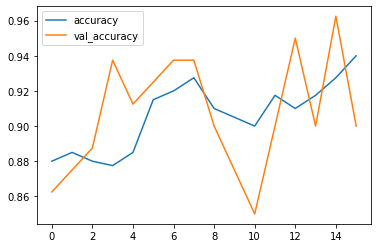

In [ ]:
history_df = pd.DataFrame(history_fine.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

We had 96.25% accuracy on validation dataset and 92.75% accuracy on trainig dataset. We ploted loss based on epoch in the above.

In [ ]:
model.load_weights('save_model_xception_autoencoder.h5')

We loaded the best model by model.load_weights():

In [ ]:
model.evaluate(X_test*255., y_test)

4/4 [==============================] - 3s 769ms/step - loss: 0.7486 - accuracy: 0.7800


[0.7486359477043152, 0.7799999713897705]

Then here we tested our model on test set which is not encoded.

We conclude that the loss for this evaluation is 0.7 and the accuracy is 78% which is not desirable.
<br>
The reason Behind this result is bad encoding. The original images are pure enough to do the training and we don't need the image deenoising with autoencoder. We did a lot of encoder/decoder architucture with different kernels, but the result wasn't satisfying enough.

# Model on original images

In [ ]:
base_model = tf.keras.applications.xception.Xception(input_shape=(224,224,3), include_top=False, weights='imagenet')
base_model.trainable = True

input_shape = (224,224,3)

inputs = tf.keras.Input(shape=input_shape) 
x = data_augmenter()(inputs)
x = tf.keras.applications.xception.preprocess_input(x)
x = base_model(x) 
x = layers.GlobalAveragePooling2D()(x) 
x = layers.Flatten()(x)
outputs = layers.Dense(5,activation = 'softmax')(x)

final_model = tf.keras.Model(inputs, outputs)

So we conlude that we should stop image denoising and do the trainig with our original images(fitting without autoencoders). firstly we modified our model.

In [ ]:
final_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

history = final_model.fit(
    x=X_train_target*255.,
    y=y_train_target,
    validation_data=(X_val*255., y_val),
    callbacks = [lr_callback],
    epochs = EPOCHS,
    batch_size=16
)


Epoch 00001: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/13
20/20 [==============================] - 52s 3s/step - loss: 1.6480 - accuracy: 0.2156 - val_loss: 1.6984 - val_accuracy: 0.2875 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler setting learning rate to 2.6666666666666667e-05.
Epoch 2/13
20/20 [==============================] - 49s 2s/step - loss: 1.5474 - accuracy: 0.3313 - val_loss: 1.6098 - val_accuracy: 0.3750 - lr: 2.6667e-05

Epoch 00003: LearningRateScheduler setting learning rate to 4.3333333333333334e-05.
Epoch 3/13
20/20 [==============================] - 50s 2s/step - loss: 1.3581 - accuracy: 0.5594 - val_loss: 1.3899 - val_accuracy: 0.4250 - lr: 4.3333e-05

Epoch 00004: LearningRateScheduler setting learning rate to 6e-05.
Epoch 4/13
20/20 [==============================] - 53s 3s/step - loss: 1.0691 - accuracy: 0.6625 - val_loss: 1.0634 - val_accuracy: 0.6250 - lr: 6.0000e-05

Epoch 00005: LearningRateScheduler setting learning rate to 6e-05

We just pull off the dropoutlayer. This time we fitted this model on the original images which is not denoised.

<AxesSubplot:>

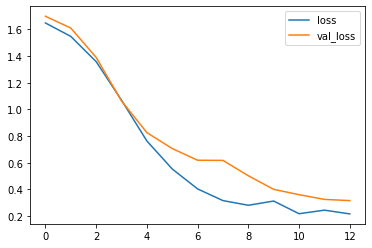

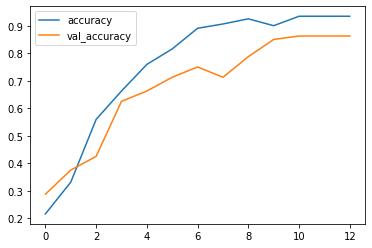

In [ ]:
history_df = pd.DataFrame(history.history)

history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

So have 86.25% accuracy on trainig dataset and 93.4% accuracy on validation dataset.

We plotted the loss based on epoch as seen above.

In [ ]:
base_model2 = final_model.layers[4]
base_model2.trainable = True

fine_tune_at = 90

for layer in base_model2.layers[:fine_tune_at]:
    layer.trainable = False

Fine-tuning like the previous one, only this time we trained the last 42 layers.

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
metrics= ['accuracy']
final_model.compile(loss="sparse_categorical_crossentropy",
              optimizer = optimizer,
              metrics=metrics)

Checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("save_model_xception_without_autoencoder.h5", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

callbacks = [Checkpoint_cb, early_stopping]

We set the optimizer, loss function and callbacks above like the previous time.

In [ ]:
initial_epochs = 13
new_epochs = 30
total_epochs =  initial_epochs + new_epochs

history_fine = final_model.fit(x=X_train_target*255., y=y_train_target,validation_data=(X_val*255., y_val),
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         callbacks=callbacks)

Epoch 13/43
10/10 [==============================] - 23s 2s/step - loss: 0.2262 - accuracy: 0.9375 - val_loss: 0.3046 - val_accuracy: 0.8750


/opt/homebrew/Caskroom/miniforge/base/envs/env1/lib/python3.10/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 14/43
10/10 [==============================] - 23s 2s/step - loss: 0.2080 - accuracy: 0.9438 - val_loss: 0.3027 - val_accuracy: 0.8875
Epoch 15/43
10/10 [==============================] - 23s 2s/step - loss: 0.1705 - accuracy: 0.9531 - val_loss: 0.2910 - val_accuracy: 0.9000
Epoch 16/43
10/10 [==============================] - 23s 2s/step - loss: 0.1216 - accuracy: 0.9719 - val_loss: 0.2673 - val_accuracy: 0.9250
Epoch 17/43
10/10 [==============================] - 23s 2s/step - loss: 0.1705 - accuracy: 0.9406 - val_loss: 0.2411 - val_accuracy: 0.9500
Epoch 18/43
10/10 [==============================] - 23s 2s/step - loss: 0.1334 - accuracy: 0.9563 - val_loss: 0.2345 - val_accuracy: 0.9000
Epoch 19/43
10/10 [==============================] - 23s 2s/step - loss: 0.1278 - accuracy: 0.9688 - val_loss: 0.2323 - val_accuracy: 0.9125
Epoch 20/43
10/10 [==============================] - 23s 2s/step - loss: 0.1271 - accuracy: 0.9625 - val_loss: 0.2095 - val_accuracy: 0.9000
Epoch 21/43
1

Fitted for more than 30 epochs.

<AxesSubplot:>

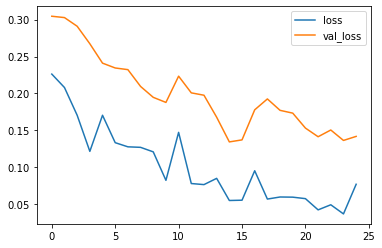

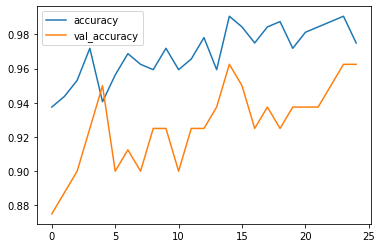

In [ ]:
history_df = pd.DataFrame(history_fine.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

As you can see, we had 99% accuracy on validation dataset and 96.25% accuracy on trainig dataset. We plotted loss based on epoch in the above.

In [ ]:
model.load_weights('save_model_xception_without_autoencoder.h5')

We loaded the best model above.

In [ ]:
model.evaluate(X_test*255., y_test)

4/4 [==============================] - 4s 762ms/step - loss: 0.1282 - accuracy: 0.9400


[0.1282070279121399, 0.9399999976158142]

We evaluated our model on test dataset above.

Then the final accuracy on the test dataset is 94% which is acceptable.

# Evaluation

In [ ]:
test_predicts = final_model.predict(X_test*255.)

In [ ]:
y_predict = np.argmax(test_predicts,axis=1)

In [ ]:
class_names

In [ ]:
test_predicts

In [ ]:
y_test

At first we predicted the classes for test dataset.

In [ ]:
plt.figure(figsize=(18,12))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(X_test[i])
    plt.title(f"Prediction: {class_names[y_test[i]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

We visualized some prediction of our model.

In [ ]:
from sklearn import metrics
print("Test set Accuracy: ", metrics.accuracy_score(y_test, y_predict))

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
print (classification_report(y_test, y_predict))
cm = confusion_matrix(y_test, y_predict)
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(cm, annot=True)
plt.show()

from sklearn.metrics import f1_score
print('f1 is: ',f1_score(y_test, y_predict, average='macro'))

The we have the confusion matrix for our prediction.

The results are in a way that you can see where model doensn't predict well in the test dataset and are clear.

In [ ]:
data = [['model with autoencoder', 78], ['model without autoencoder', 94], ['model of the article', 97.6]]

df = pd.DataFrame(data, columns=['model', 'accuracy(%)'])

In [ ]:
df

Then at the end we can have a dataframe of accuracy our models comparing to the accuracy of the article(in percentage).

We conclude that our main model got 94% accuracy on test dataset and 99% accuracy on training set which is good compare to the article which has a 97.6% accuracy.